In [114]:
import torch
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
import numpy as np
torch.__version__

'2.4.0'

Make a problem with 2 variables

In [11]:
from sklearn.datasets import make_circles

X, y = make_circles(1000, noise=0.1, random_state=23)
X,y[:10]

(array([[ 0.75921612,  0.12538944],
        [-0.4849095 , -0.57418448],
        [-0.915094  ,  0.46046701],
        ...,
        [ 0.84696809,  0.48985966],
        [-0.80217857,  0.18905475],
        [ 0.26813826,  0.84766116]]),
 array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0]))

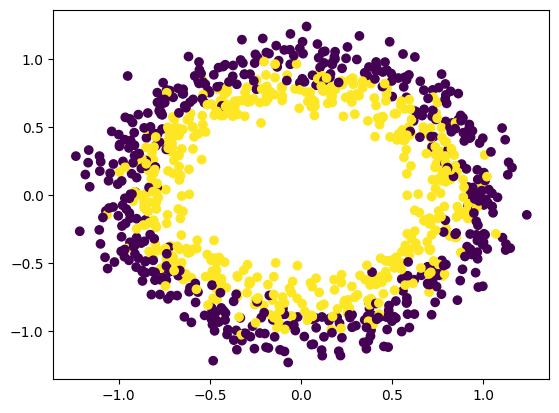

In [12]:
plt.scatter(X[:,0], X[:,1], c=y)

To pass data to a tensor

In [13]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [14]:
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size= 0.2, random_state=23)
Xtv.shape, Xts.shape, ytv.shape, yts.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu" #To pass the data to the gpu if its available
device

'cpu'

In [16]:
class ClassifModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) #Recieve 5 and make it 1
    def forward(self, x: torch.Tensor):
        return self.layer_2(self.layer_1(x)) #First the tensor pass from layer_2 and the layer_1

model = ClassifModel().to(device)
model

ClassifModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

If i want it sequential for sake of simplicity i can run

In [19]:
model_1 = nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

The problem with this is that runs sequential, so if we want to do some steps before or after training we cant do it, for that is better to use a subclass approach 

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

Make a acurracy function

In [22]:
def acurracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() #eq is the built in function to see if 2 tensors are equal
    return (correct / len(y_pred)) * 100

Example

In [25]:
torch.eq(torch.tensor([2, 1, 1]),torch.tensor([2, 2, 1])).sum().item()

2

Understanding how the model pass the data and how interpreter it, if we pass the raw data to the model we get something like this

In [26]:
Xtv, Xts, ytv, yts = Xtv.to(device), Xts.to(device), ytv.to(device), yts.to(device) 

In [30]:
y_pred = model_1(Xtv)
y_pred[:10]

tensor([[-0.5805],
        [-0.6873],
        [-0.4461],
        [-0.2390],
        [-0.5348],
        [-0.2490],
        [-0.2747],
        [-0.3065],
        [-0.5564],
        [-0.4252]], grad_fn=<SliceBackward0>)

So we use a function to interpreter those values called logits

In [31]:
y_pred = torch.sigmoid(y_pred)
y_pred[:10]

tensor([[0.3588],
        [0.3346],
        [0.3903],
        [0.4405],
        [0.3694],
        [0.4381],
        [0.4317],
        [0.4240],
        [0.3644],
        [0.3953]], grad_fn=<SliceBackward0>)

Its seems more like a probability being a class or another

In [37]:
y_pred = torch.round(y_pred)

print(torch.eq(y_pred, ytv)[:5])
y_pred.squeeze()[:5] # To make it a row

tensor([[ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False,  True]])


tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)

In [118]:
def train_funcion(model, optimizer, multi=False, loss_fn=loss_fn, epochs=epochs, Xtv=Xtv, ytv= ytv, Xts=Xts, yts=yts):
    for epoch in range(epochs):
        model.train()
        if multi:
            y_logits = model(Xtv)
        else:
            y_logits = model(Xtv).squeeze()
        loss = loss_fn(y_logits, ytv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.inference_mode():
            if epoch % 200 == 0:
                if multi:
                    y_logits = model(Xts)
                    y_pred = torch.softmax(y_logits, 1).argmax(1)
                else:
                    y_logits = model(Xts).squeeze()
                    y_pred = torch.round(torch.sigmoid(y_logits))
                loss = loss_fn(y_logits, yts)
                acc = acurracy(yts, y_pred)
                print(f"Epoch {epoch} | loss {loss} | acurracy {acc}")

In [45]:
torch.manual_seed(23)
epochs = 1000
train_funcion(model_1,optimizer)

Epoch 0 | loss 0.7632099986076355 | acurracy 44.5
Epoch 200 | loss 0.701007068157196 | acurracy 41.5
Epoch 400 | loss 0.6993134021759033 | acurracy 38.5
Epoch 600 | loss 0.6985783576965332 | acurracy 38.5
Epoch 800 | loss 0.6981890797615051 | acurracy 43.5


In [46]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

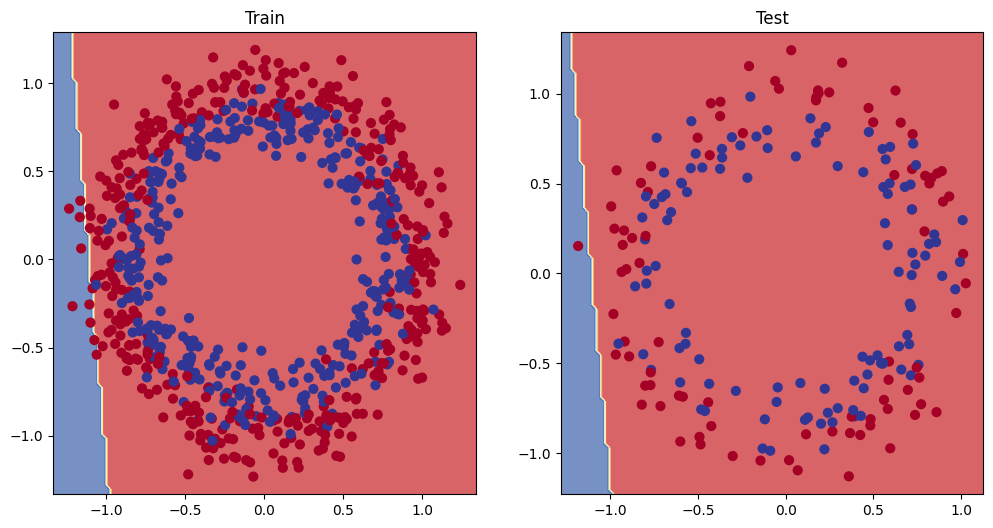

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, Xts, yts)

### Add non linearity

With a activation function

In [48]:
class ClassifModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=16) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=16, out_features=16) #Recieve 5 and make it 1
        self.layer_3 = nn.Linear(in_features=16, out_features=1) #Recieve 5 and make it 1
        self.relu = nn.ReLU()
    def forward(self, x: torch.Tensor):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) #First the tensor pass from layer_2 and the layer_1

model_3 = ClassifModel().to(device)
model_3

ClassifModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [50]:
torch.manual_seed(23)
epochs = 1000
train_funcion(model_3,optimizer)

Epoch 0 | loss 0.7034926414489746 | acurracy 44.5
Epoch 200 | loss 0.6956318020820618 | acurracy 50.5
Epoch 400 | loss 0.6904233694076538 | acurracy 54.50000000000001
Epoch 600 | loss 0.6710608601570129 | acurracy 57.99999999999999
Epoch 800 | loss 0.6258395910263062 | acurracy 67.0


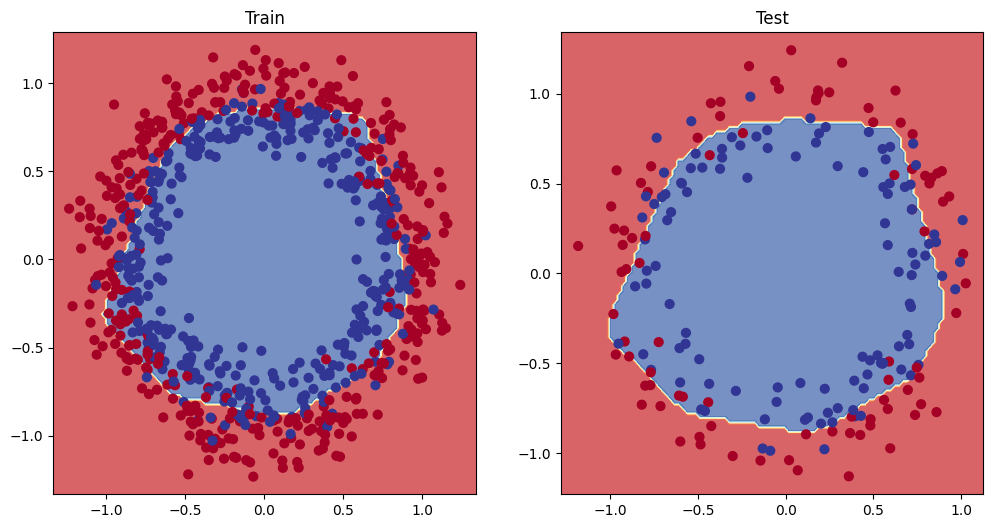

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, Xts, yts)

In [64]:
class ClassifModel3(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=16) #Its like neurons, enter the 2 features, make it 5
        self.layer_2 = nn.Linear(in_features=16, out_features=16) #Recieve 5 and make it 1
        self.layer_3 = nn.Linear(in_features=16, out_features=1) #Recieve 5 and make it 1
        self.sigmoid = nn.Sigmoid()
    def forward(self, x: torch.Tensor):
        return self.layer_3(self.sigmoid(self.layer_2(self.sigmoid(self.layer_1(x))))) #First the tensor pass from layer_2 and the layer_1

model_4 = ClassifModel3().to(device)
model_4

ClassifModel3(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [65]:
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.1)

In [66]:
torch.manual_seed(23)
epochs = 1000
train_funcion(model_4,optimizer)

Epoch 0 | loss 0.867306649684906 | acurracy 44.5
Epoch 200 | loss 0.6576213240623474 | acurracy 61.0
Epoch 400 | loss 0.4837462604045868 | acurracy 80.0
Epoch 600 | loss 0.49735504388809204 | acurracy 79.0
Epoch 800 | loss 0.5296304821968079 | acurracy 78.5


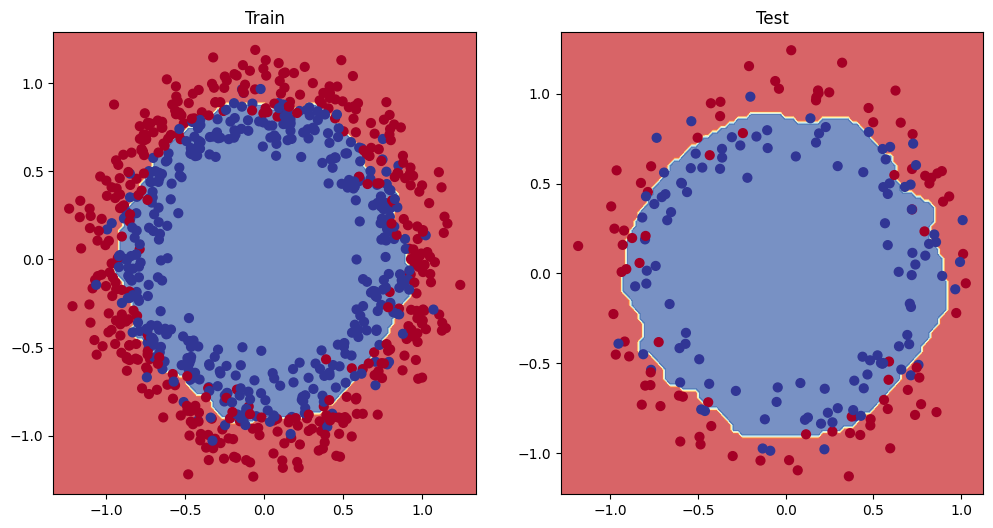

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, Xts, yts)

### For multiclass problems

In [94]:
from sklearn.datasets import make_blobs

X_blob , y_blob = make_blobs(
    1000, 2, centers=4, cluster_std=2, random_state=23
)

X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.LongTensor)

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size= 0.2, random_state=23)
Xtv.shape, Xts.shape, ytv.shape, yts.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

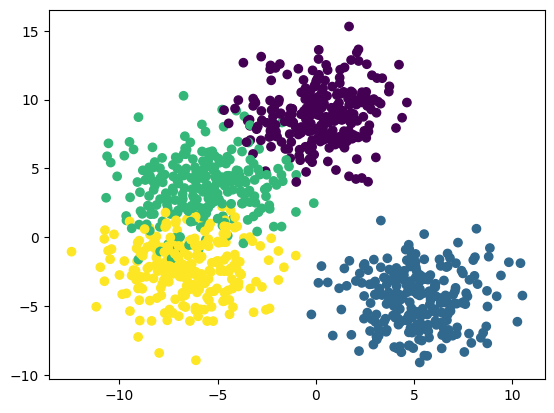

In [95]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob)

In [98]:
class BloobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 10,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x: torch.Tensor):
        return self.linear_stack(x)

model_5 = BloobModel(2, 4).to(device)
model_5

BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [99]:
loss_fn = nn.CrossEntropyLoss() #Remember to change the loss function for each problem
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.01)

In [100]:
Xtv, Xts, ytv, yts = Xtv.to(device), Xts.to(device), ytv.to(device), yts.to(device) 

In [101]:
model_5(Xtv)[:5]

tensor([[-0.2325, -0.3366, -0.8108,  0.0842],
        [ 0.1209, -0.6350, -0.4533, -0.2331],
        [ 0.1899, -0.5259, -0.2077, -0.2420],
        [ 0.1065, -0.8695, -0.9315, -0.4474],
        [ 0.2595, -0.1294,  0.0357, -0.0429]], grad_fn=<SliceBackward0>)

In multiclass problems we use the softmax to interpreter the results, remember to do like: logits(raw data from the model) - prediction probabilities - prediction labels

In [102]:
y_logits = model_5(Xtv)

y_pred_probs = torch.softmax(y_logits, 1)
print(y_pred_probs[:5])

tensor([[0.2608, 0.2350, 0.1463, 0.3580],
        [0.3657, 0.1717, 0.2059, 0.2567],
        [0.3559, 0.1740, 0.2391, 0.2311],
        [0.4337, 0.1634, 0.1536, 0.2493],
        [0.3109, 0.2107, 0.2486, 0.2298]], grad_fn=<SliceBackward0>)


To extract the class of those possibilities we need to see what is the most probable label

In [103]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2608, 0.2350, 0.1463, 0.3580], grad_fn=<SelectBackward0>)
tensor(3)


If theres a problem from long tensor or float just change the data type

In [119]:
train_funcion(model_5, optimizer, multi=True)

Epoch 0 | loss 0.13109906017780304 | acurracy 95.0
Epoch 200 | loss 0.130365252494812 | acurracy 95.0
Epoch 400 | loss 0.1298423558473587 | acurracy 95.0
Epoch 600 | loss 0.12941935658454895 | acurracy 95.0
Epoch 800 | loss 0.1290646344423294 | acurracy 95.0


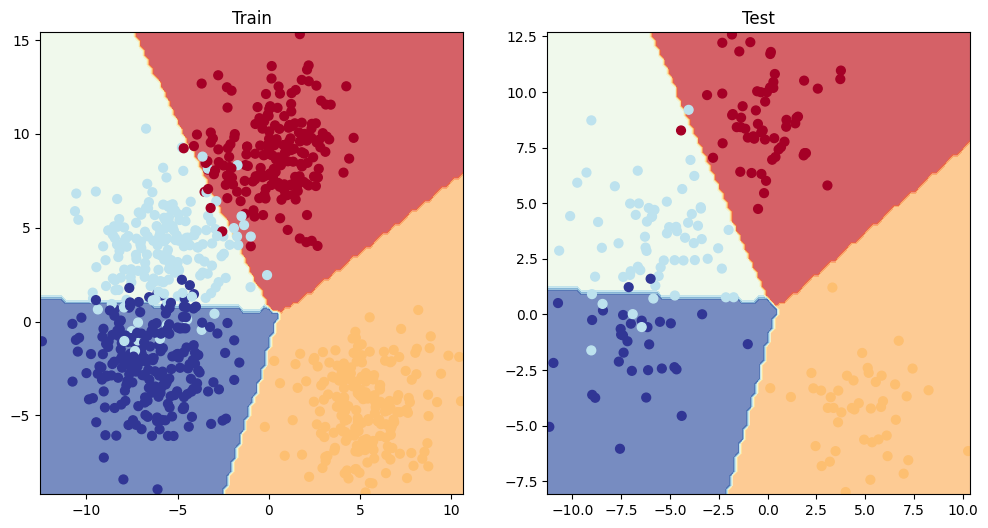

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, Xts, yts)

Withouth ReLu

In [124]:
class BloobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 10,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x: torch.Tensor):
        return self.linear_stack(x)

model_6 = BloobModel(2, 4).to(device)
model_6

BloobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [125]:
loss_fn = nn.CrossEntropyLoss() #Remember to change the loss function for each problem
optimizer = torch.optim.SGD(model_6.parameters(), lr=0.01)

In [126]:
train_funcion(model_6, optimizer, multi=True)

Epoch 0 | loss 1.548006296157837 | acurracy 23.5
Epoch 200 | loss 0.2083827406167984 | acurracy 94.5
Epoch 400 | loss 0.16594362258911133 | acurracy 94.5
Epoch 600 | loss 0.1527380347251892 | acurracy 94.5
Epoch 800 | loss 0.1463642716407776 | acurracy 94.5


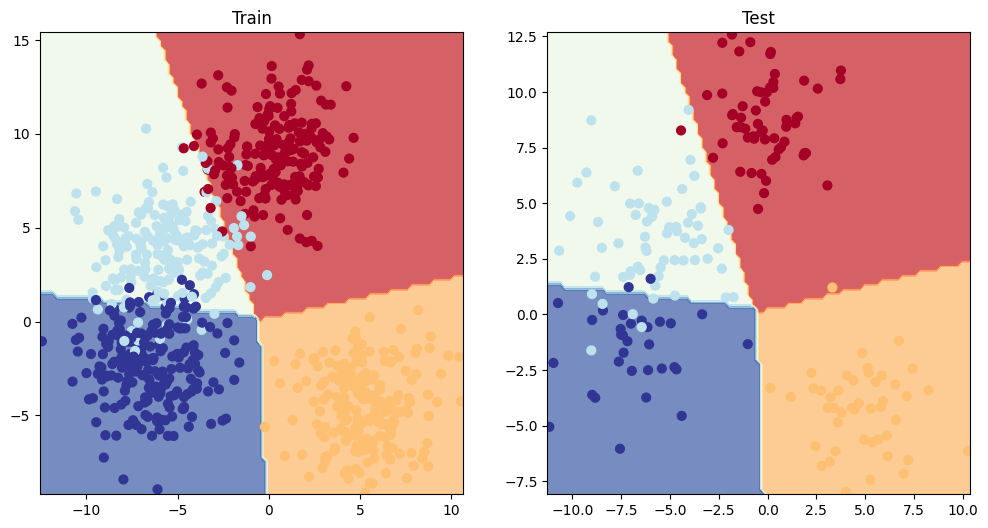

In [127]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, Xtv, ytv)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, Xts, yts)